# Классификация госконтрактов по объектам закупки

## Импорт библиотек

In [1]:
import os
import re
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from ydata_profiling import ProfileReport
import warnings
warnings.filterwarnings('ignore', module='ydata_profiling')

from plotly import graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.templates["plotly_dark"]
pio.renderers.default = "svg"

pd.options.display.float_format = '{:0.3f}'.format
pd.options.mode.chained_assignment = None
pd.set_option('display.expand_frame_repr', False)

plt.rcParams.update({'lines.linewidth': 1.25,
                     'grid.linewidth': 0.5,
                     'grid.alpha': 0.5,
                     'figure.constrained_layout.use': True,
                     'figure.figsize': (10, 6)})

%config InlineBackend.figure_format = 'retina'

## Исследовательский анализ данных  EDA

Загрузим сформированный на первом шаге датафрейм

In [2]:
df = pd.read_parquet('../data/fzdata.parquet')
df.shape

(2556154, 10)

Удалим полные дубликаты.

In [3]:
print(df[df.duplicated()].shape)
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True, drop=True)

(296592, 10)


ИНН для физических лиц состоит из 12 цифр. Для юридических лиц ИНН присваивается при постановке на учет в налоговом органе при их создании и состоит из 10 цифр.

Учтем этот факт.

In [4]:
df = df[df['inn'].map(lambda x: len(str(x)) in [10,12])]

Уникальных категорий слишком много, нужно воспользоваться методами по обработке естественного языка чтобы использовать данный признак.

In [5]:
df['category'].unique().size

1439840

Малая часть контрактов обладает отрицательной длительность контракта. Это явная ошибка, исключим такие данные.

In [6]:
df[df['contract_duration']<0].shape

(156, 10)

In [7]:
df = df[df['contract_duration']>=0]

Большенство контрактов выполняется менее чем за 100 дней.

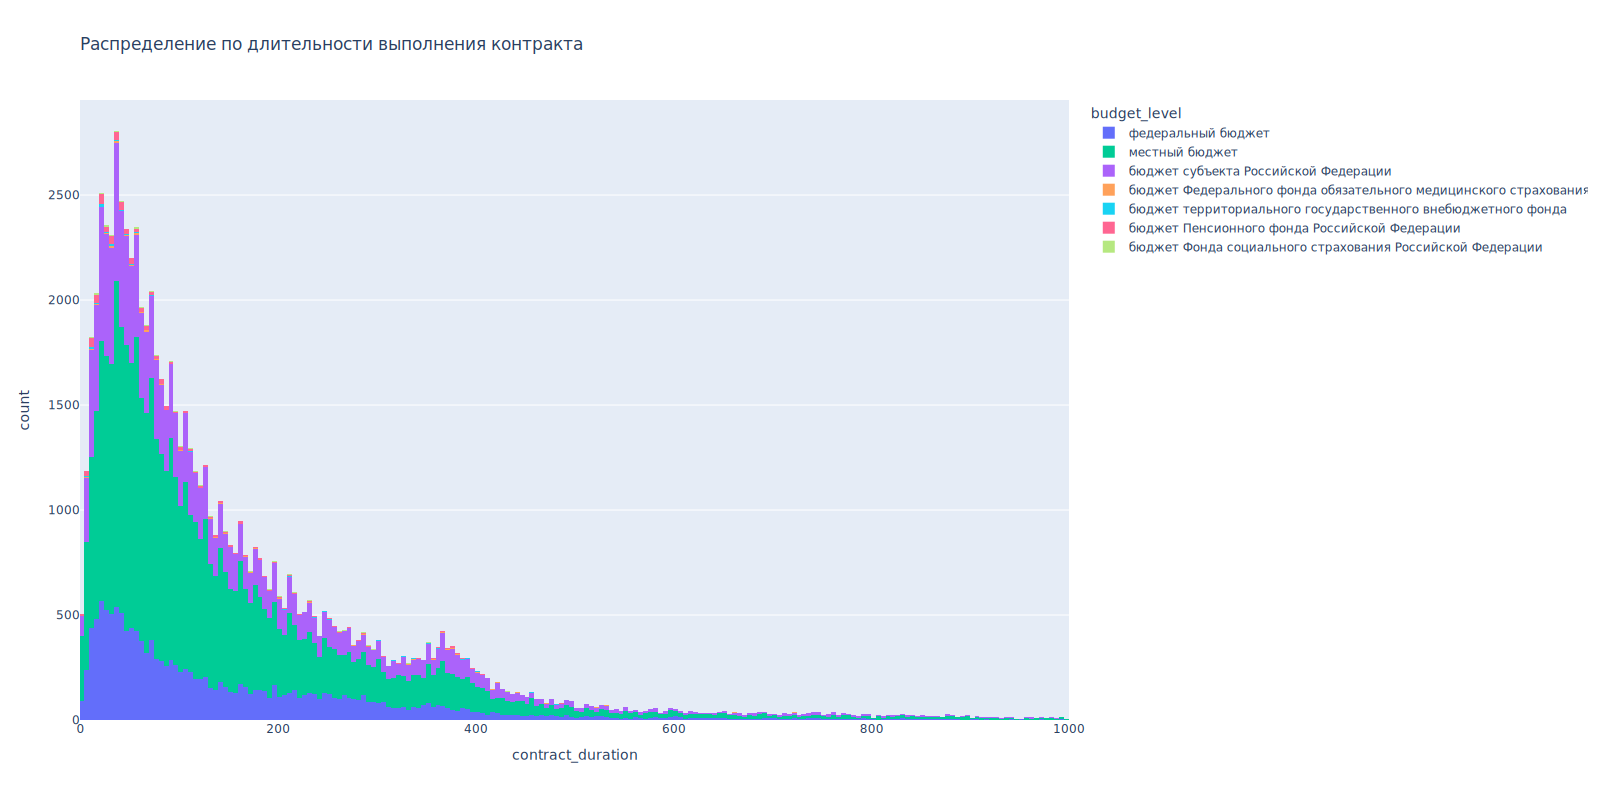

In [8]:
fig = px.histogram(
    df.sample(100000), x="contract_duration",
    color="budget_level",
    title='Распределение по длительности выполнения контракта')
fig.update_layout(
    autosize=False,
    width=1600,
    height=800)
fig.update_xaxes(range=[0, 1000])
fig.show()

Контрактов выполненных более чем за 7 лет в базе нет.

In [9]:
df[df['contract_duration']>365*7].shape[0]

0

Есть выбросы по стоимости контракта, уберем всё больше 250 млн. руб.

In [10]:
print(df[df['price']>250*10**6].shape[0])
print(f"{(df[df['price']>250*10**6].shape[0] / df.shape[0]):.2%}")

7940
0.39%


In [11]:
df = df[df['price']<250*10**6]
df['price'].describe()

count     2016183.000
mean      3655875.691
std      15016241.001
min             0.000
25%        139100.000
50%        490590.000
75%       1740172.020
max     249999990.000
Name: price, dtype: float64

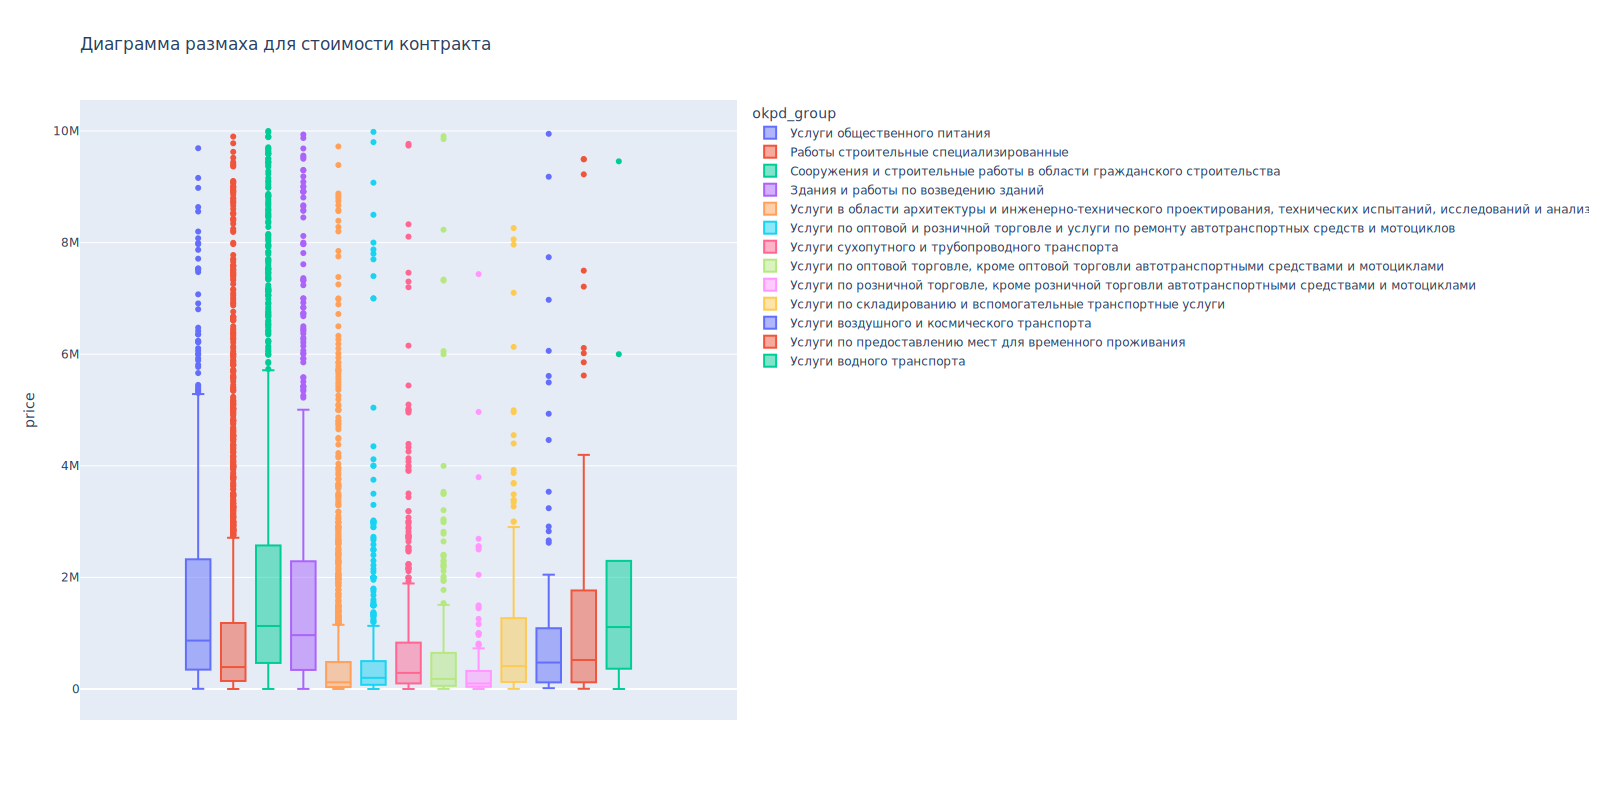

In [12]:
fig = px.box(
    df[df['price']<10*10**6].sample(10000),
    color="okpd_group",
    y="price",
    title='Диаграмма размаха для стоимости контракта'
)
fig.update_traces(quartilemethod="exclusive") # "exclusive" or "inclusive", or "linear" by default
fig.update_layout(
    autosize=False,
    width=1600,
    height=800)

fig.show()

Воспользуемся библиотекой **ydata_profiling** для краткого анализа имеющихся данных.

[Посмотреть отчет](../data/profiling-report.html)

In [13]:
profile = ProfileReport(df.sample(250000), title="Profiling Report", explorative=True)
profile.to_file("../data/profiling-report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Из отчета видно что существуют крупные исполнители на которых приходится много заказов.

In [14]:
df['inn'].unique().size

229241

Кроме того, большая часть закупок приходится на крупные города (77 - Москва, 78 - СПБ) и их области.

> Некоторые регионы представлены очень слабо.

In [15]:
df['region_code'].value_counts()

region_code
77    147002
78     98134
50     67053
16     56373
23     41884
       ...  
03        60
09        56
07        42
01        37
06         1
Name: count, Length: 85, dtype: int64

Заполним пропуски в **region_code** используя SimpleImputer. Отметим высокую корреляцию region_code и inn.

In [16]:
imp = SimpleImputer(strategy="most_frequent")
tmp_array = imp.fit_transform(
    pd.DataFrame(df[['inn', 'region_code']].values, dtype="category")
)

print(f"Было пропусков: {df.region_code.isna().sum()}")
df['region_code'] = tmp_array[:,1]
df['region_code'].isna().sum()
print(f"Осталось пропусков: {df.region_code.isna().sum()}")

Было пропусков: 533599
Осталось пропусков: 0


## Feature Engineering и определение целевой переменной

Регионы можно отнести к категориальному признаку, но выборка по ним не сбалансированная, поэтому проведем бинификацию.

In [17]:
df['region_cnt'] = df.groupby('region_code')['region_code'].transform('count')
df['region_cnt'].value_counts().values

array([680601,  98134,  67053,  56373,  41884,  40493,  39074,  37902,
        37815,  34750,  29725,  27231,  26757,  26552,  24281,  24048,
        23355,  21603,  21510,  21235,  21164,  21055,  20277,  19349,
        18385,  18053,  18031,  17686,  17512,  17204,  17017,  16967,
        16690,  16425,  15372,  15003,  14865,  14270,  14142,  13453,
        12892,  12753,  12724,  12688,  12374,  11997,  11989,  11357,
        10993,  10634,  10592,  10093,   9991,   9463,   9426,   9383,
         9264,   8984,   8510,   8299,   8217,   8150,   7049,   7044,
         6529,   6148,   5956,   5650,   5574,   3634,   3103,   2951,
         2905,   1751,   1715,   1274,    210,    189,    121,    115,
           60,     56,     42,     37,      1])

In [18]:
# Зададим 5 интервала так чтобы данные распределились более равномерно
bins = [0, 14000, 21000, 37000, 80000, np.infty]
labels = ['small', 'medium', 'big', 'huge', 'capitals']
df['region_size'] = pd.cut(df['region_cnt'], bins, labels=labels)
df.groupby(['region_size'], observed=True).agg(dict(region_cnt=['count']))

,region_cnt
,count
region_size,
small,306340
medium,287248
big,323266
huge,320594
capitals,778735


Переведем ИНН в категории по степени крупности исполнителя. Чем больше контрактов, тем вероятнее что мы имеем дело не с ИП, а с бизнесом покрупнее.

In [19]:
df['contact_cnt'] = df.groupby('inn')['inn'].transform('count')
df['executor_size'] = pd.cut(df['contact_cnt'], 4, labels=["small", "medium", "big", "huge"])

df.groupby(['executor_size'], observed=True).agg(dict(contact_cnt=['count', 'mean']))

contact_cnt         
                    count     mean
executor_size                     
small             1949828   75.723
medium              44719 1467.082
big                 13154 2673.947
huge                 8482 4242.624

Сохраним region_size и executor_size.

In [20]:
region_size = df.groupby(['region_code'], observed=True)['region_size'].first()
region_size.to_frame().to_parquet(('../data/region_size.parquet'), index=True)

executor_size = df.groupby(['inn'], observed=True)['executor_size'].first()
executor_size.to_frame().to_parquet('../data/executor_size.parquet', index=True)

На основе кодов ОКПД2 определим целевую переменную **target_group**.

- Код 43.22 не представлен (Подключение коммуникаций).
- Строительный надзор не имеет четкой группы.

In [21]:
df['okpd_code'].value_counts()

okpd_code
43.2    256050
42.1    248979
71.1    226413
43.9    173455
43.3    170089
71.2    131982
41.2    129528
56.2    110330
45.2     99038
42.9     73894
49.3     70198
42.2     43368
52.2     35900
43.1     29481
46.4     24621
49.4     21254
51.1     20536
56.1     19527
41.1     11869
55.1     11469
47.7     10101
46.1      9956
49.5      9634
55.9      8763
46.7      7233
52.1      6957
46.3      6764
47.6      6219
45.3      5260
47.3      4575
47.5      4072
47.4      3847
46.5      3349
47.1      2572
55.2      2499
46.6      2470
45.1      2185
49.1      2004
47.2      1570
49.2      1406
55.3      1333
46.9      1297
47.9       829
51.2       815
50.3       749
50.4       637
46.2       388
50.2       236
45.4       208
50.1       134
47.8       106
56.3        34
Name: count, dtype: int64

In [22]:
df['okpd_group'].value_counts()

okpd_group
Работы строительные специализированные                                                                                 629075
Сооружения и строительные работы в области гражданского строительства                                                  366241
Услуги в области архитектуры и инженерно-технического проектирования, технических испытаний, исследований и анализа    358395
Здания и работы по возведению зданий                                                                                   141397
Услуги общественного питания                                                                                           129891
Услуги по оптовой и розничной торговле и услуги по ремонту автотранспортных средств и мотоциклов                       106691
Услуги сухопутного и трубопроводного транспорта                                                                        104496
Услуги по оптовой торговле, кроме оптовой торговли автотранспортными средствами и мотоциклами              

Данных достаточно чтобы выделить 3 группы, что позволит свести задачу к мультиклассовой классификации.

> СМР почти в 5 раз больше чем ПИР следовательно выборка не сбалансированная.

In [23]:
# Выделим коды для каждого класса
codes_all = set(df['okpd_code'].unique())
codes_cmp = set(['41.1','71.1'])
codes_pir = set(
    [x for x in codes_all if x.startswith('41')]
    + [x for x in codes_all if x.startswith('42')]
    + [x for x in codes_all if x.startswith('43')]
)
codes_pir = codes_pir.difference(codes_cmp)
codes_other = codes_all.difference(codes_cmp.union(codes_pir))

for name, arr in zip(['СМР', 'ПИР', 'ДРУГИЕ'], [codes_cmp, codes_pir, codes_other]):
    print(name, arr)

СМР {'41.1', '71.1'}
ПИР {'43.1', '41.2', '42.9', '43.9', '42.1', '43.3', '43.2', '42.2'}
ДРУГИЕ {'45.3', '52.2', '45.1', '49.2', '51.2', '55.2', '46.4', '56.3', '47.2', '46.5', '56.1', '46.6', '51.1', '71.2', '47.3', '55.1', '49.4', '55.9', '55.3', '47.8', '52.1', '46.7', '45.4', '50.3', '46.9', '50.4', '46.2', '46.1', '50.1', '49.1', '47.9', '47.4', '49.5', '49.3', '47.7', '45.2', '56.2', '50.2', '46.3', '47.5', '47.6', '47.1'}


In [24]:
df['target_group'] = "None"

df.loc[df['okpd_code'].isin(codes_cmp), ['target_group']] = 'СМР'
df.loc[df['okpd_code'].isin(codes_pir), ['target_group']] = 'ПИР'
df.loc[df['okpd_code'].isin(codes_other), ['target_group']] = 'ДРУГИЕ'

df['target_group'].value_counts()

target_group
ПИР       1124844
ДРУГИЕ     653057
СМР        238282
Name: count, dtype: int64

Удалим лишние признаки учитывая при этом высокую корреляцию и возможную целевую утечку (target leakage) если оставить ОКПД.

In [25]:
df.drop(
    ['inn', 'region_code', 'contact_cnt', 'okpd_code', 'okpd_group', 'region_cnt', 'termination_reason'],
    axis=1, inplace=True
)

Категория важный признак, предположительно именно по описанию можно будет определить класс **target_group**.

> Удалим данные с пропуском в **category**

In [26]:
df.dropna(subset=['category'], inplace=True)

Пропуски остаются только в **budget_level**, заполним их значением 'unknow'.

In [27]:
print(df.isna().sum().where(lambda x: x > 0).dropna())
df.fillna(dict(budget_level='unknow'), inplace=True)
display(df['target_group'].value_counts())

budget_level   366389.000
dtype: float64


target_group
ПИР       1076039
ДРУГИЕ     563554
СМР        225870
Name: count, dtype: int64

In [28]:
display(df.sample(5))
print(df.shape)

,status,category,budget_level,contract_duration,price,region_size,executor_size,target_group
709214,Исполнение контракта прекращено,Оказание услуг по организации питания учащихся,местный бюджет,157.000,724312.000,capitals,small,ДРУГИЕ
338048,Контракт исполнен,Услуги по комплексному обслуживанию зданий учр...,unknow,441.000,670039.350,capitals,small,ПИР
350255,Контракт исполнен,Выполнение работ по установке узлов учета тепл...,местный бюджет,191.000,24447600.740,capitals,small,ПИР
324995,Контракт исполнен,Оказание услуг по выполнению физико-химических...,федеральный бюджет,210.000,244440.000,small,small,ДРУГИЕ
1188275,Контракт исполнен,Выполнение работ по текущему ремонту столовой ...,unknow,36.000,236859.210,capitals,small,ПИР


(1865463, 8)


Сохраним датафрейм в parquet формате.

In [29]:
df.reset_index(drop=True, inplace=True)
df.to_parquet('../data/fzdata-clean.parquet')